In [1]:
import matplotlib.pyplot as plt
import pulp # For linear programming
import numpy as np
from pathlib import Path
from scipy.stats import binom
import time
import pickle
import pandas as pd
import math
import random
import time

from tools import computation
from tools import gradient
from tools import write_result
from tools import online_learning
from tools import parameter_generator

ModuleNotFoundError: No module named 'pulp'

# Tools to generate sample average approximation problems

In [2]:
def attack_non_attacks(p, N):
"""Given a probability of attack and a size of training set returns
a number of attacks drawn according to a binomial distribution
and the corresponding number of non-attacks"""
    nb_attacks = np.random.binomial(N, p)
    nb_non_attacks = N - nb_attacks
    return nb_attacks, nb_non_attacks

def sample_average_approx(cleaned_dataset, alpha):
"""Creates parameters for the sample average approximation problem on the
kaggle data set"""
    N = cleaned_dataset.shape[0]
    PN = [1/N for i in range(N)]
    gain_success = [[]]
    CFA = []
    loss_failure = [[0 for i in range(N)]]
    for i, j in cleaned_dataset.iterrows():
        gain_success[0].append(j["Amount"])
        CFA.append(j["Amount"]*alpha)
    return PN, gain_success, loss_failure, CFA

def sample_average_general(PN, gain_succes, loss_failure, CFA, v_list):
"""Creates parameters for the sample average approximation problem for a general game
given the parameters of the game"""
    N = len(v_list)
    m = len(gain_success) # Number of attacker
    PN_sample = [1/N for i in range(N)]
    gain_success_sample = [[] for j in range(m)]
    CFA_sample = []
    loss_failure_sample = [[] for j in range(m)]
    for v in v_list:
        for j in range(m):
            gain_success_sample[j].append(gain_success[j][v])
            loss_failure_sample[j].append(loss_failure[j][v])
        CFA_sample.append(CFA[v])
    return PN_sample, gain_success_sample, loss_failure_sample, CFA_sample

# Quick analysis of the data set

In [3]:
df = pd.read_csv('./creditcard.csv')
print(df.head())

# Printing important metrics about the data set
mean = df["Amount"].mean()
maximum = df["Amount"].max()
class_count = df["Class"].value_counts()
non_attack = class_count[0]
attack = class_count[1]
total = df.shape[0]
attack_proba = attack/total
# Data frame with only class 0 vectors, represents empiric non-attacker distribution
df_cleaned = df[df.Class==0]
print("Size of the data set", total)
print("Number of malicious transactions", attack)
print("Number of non-malicious transactions", non_attack)
print("Proportion of attacker", attack_proba)
print("Mean value of transactions", mean)
print("Maximum transaction value", maximum)

# Representation of the non-attacker distribution on a subset of amounts (<= 700)
list_amounts = df_cleaned["Amount"].tolist() 
list_low_amounts = [i for i in list_amounts if i <= 701] # Retrieve relevant transactions
fig,ax = plt.subplots(1,1)
ax.hist(list_low_amounts, bins = [i for i in range(701)], label='Transactions')
ax.set_xticks([100*i for i in range(8)])
ax.set_xlabel('Amount', fontsize=17)
ax.set_ylabel('Number of transactions', fontsize=17)
ax.legend(loc='lower right', fontsize=14)
plt.tight_layout()
plt.savefig('plots/empirical_pn', bbox_inches = 'tight', dpi=400)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# Experiment parameters

In [4]:
list_l = np.linspace(0.001, 0.1, 20)
m = 1  # We only consider one attacker in the bank fraud scenario

# Sample average approximation on the kaggle data set

## Experiments (optional)

In [5]:
G_list_saa = [] # List of strategies of the defender
computation_time = []
for l in list_l:
    current_time_list = []
    # Creates the sample average problem
    PN, gain_success, loss_failure, CFA = sample_average_approx(df_cleaned, l)
    n = len(PN)
    # We compute the equilibrium 10 times to have a more precise estimate of the computation time
    for i in range(10):
        start = time.time()
        # Solving the sample average problem
        bne_defender = computation.solve_defender(
                attack_proba, n, m, loss_failure, gain_success, PN, CFA, [1])
        end = time.time() 
        current_time_list.append(end - start)
    # Retrieve parameters of the equilibrium
    G_list_saa.append(computation.retrieve_gain_eql(bne_defender, m))
    objective = pulp.value(bne_defender.objective)
    computation_time.append(current_time_list)

# Save computation results
file = open('pickle/G_list_saa', 'wb')
pickle.dump(G_list_saa, file)
file.close()

file = open('pickle/Computation_time', 'wb')
pickle.dump(computation_time, file)
file.close()

KeyboardInterrupt: 

## Plot (Figure 4)

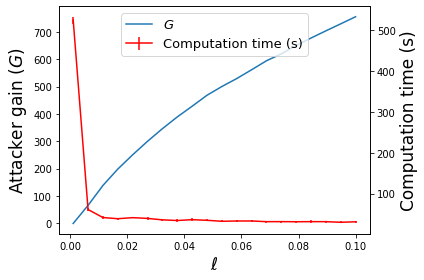

In [25]:
# Retrieve previously computed parameters
with open("pickle/G_list_saa","rb") as f:
    G_list_saa = pickle.load(f)
with open("pickle/Computation_time","rb") as f:
    computation_time = pickle.load(f)

fig,ax = plt.subplots(1,1)
# Plot computation time
ax2 = ax.twinx()
mean_computation = np.mean(computation_time, axis=1)
std_computation = np.std(computation_time, axis=1)
ax2.errorbar(list_l, mean_computation, std_computation, color='r', label='Computation time (s)')
ax2.set_ylabel('Computation time (s)', fontsize=17)

# Plot trained parameters
ax.plot(list_l, G_list_saa, label=r'$G$')
ax.set_xlabel(r'$\ell$', fontsize=17)
ax.set_ylabel(r'Attacker gain ($G$)', fontsize=17)

# Putting all labels in a single legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper center', fontsize=13)
plt.tight_layout()
plt.savefig('plots/G_Gain_saa', bbox_inches = 'tight', dpi=400)

# Illustration of previously computed strategies (Figure 1)

In [20]:
# Plotting equilibrium probability of detection functions for some values of l
pi_lowest = [0] + [max(0, (i - G_list_saa[1][0]) / i) for i in range(1, 701)]
pi_middle = [0] + [max(0, (i - G_list_saa[7][0]) / i) for i in range(1, 701)]
pi_high = [0] + [max(0, (i - G_list_saa[14][0]) / i) for i in range(1, 701)]
fig,ax = plt.subplots(1,1)
ax2=ax.twinx()
ax2.set_ylabel("Probability of detection", fontsize=17)
ax2.set_ylim(0, 1)
ax2.plot([i for i in range(701)], pi_lowest, color='r', label=r'$\pi_{G_{0.006}}$')
ax2.plot([i for i in range(701)], pi_middle, color='purple', label=r'$\pi_{G_{0.037}}$')
ax2.plot([i for i in range(701)], pi_high, color='orange', label=r'$\pi_{G_{0.074}}$')

# Plotting the non-attacker empirical distribution
ax.hist(list_low_amounts, bins = [i for i in range(701)], label='Transactions')
ax.set_xticks([100*i for i in range(8)])
ax.set_xlabel('Amount', fontsize=17)
ax.set_ylabel('Number of transactions', fontsize=17)
ax.legend(loc='upper left', fontsize=14)
ax2.legend(bbox_to_anchor = [0.65, 0.85], fontsize=14)
plt.tight_layout()
plt.savefig('plots/empirical_pn_with_pi', bbox_inches = 'tight', dpi=400)

[0.001      0.00621053 0.01142105 0.01663158 0.02184211 0.02705263
 0.03226316 0.03747368 0.04268421 0.04789474 0.05310526 0.05831579
 0.06352632 0.06873684 0.07394737 0.07915789 0.08436842 0.08957895
 0.09478947 0.1       ]


# Training on artificial bank fraud

## Parameters

In [ ]:
# Parameters of the artificial bank fraud game
amount = int(maximum)
theta = 88/amount
m = 1
list_l = np.linspace(0.001, 0.1, 20)
gain_success = [[i for i in range(amount)]]
loss_failure = [[0 for i in range(amount)]]
PN = [binom.pmf(i, amount, theta) for i in range(amount)]
cfa_base = np.arange(amount)
p = 0.001727

# Parameters of the experiment
nb_run = 300
experiment_list = [list_l[0], list_l[1], list_l[7], list_l[14]]
nb_experiments = len(experiment_list)
N_list = [10, 200, 500, 1000, 2000, 3000, 5000]

## Experiments (optional)

In [39]:
# Lists of results
proba_list_all = []
approximation_list_all = [[] for i in range(len(experiment_list))]

# We go through experiments by increasing l
for index, l in enumerate(experiment_list):
    CFA = cfa_base*l  # Adapts false alarms to the current experiment
    approximation_list = [[]for i in range(len(N_list))]
    probas = [0 for i in range(len(N_list))]
    
    # Computes equilibrium of the true problem
    bne_full = computation.solve_defender(
                p, amount, m, loss_failure, gain_success, PN, CFA, [1])
    G_eql = computation.retrieve_gain_eql(bne_full, m)
    proba_detection = computation.give_probability(G_eql, loss_failure, gain_success)
    objective = (
            computation.compute_gain_defender(G_eql, [1], proba_detection, CFA, PN, p)
        )
    # For each l, we perform training on different training set size
    for i, N in enumerate(N_list):
        # For each training set size, we produce multiple random training sets
        for seed in range(nb_run):
            np.random.seed(seed)
            # Generating the training problem
            nb_attacks, nb_non_attacks = attack_non_attacks(p, N)
            p_training = nb_attacks/N
            # Creates the sample average problem
            v_list = np.random.choice(range(amount), nb_non_attacks, p=PN)
            PN_sample, gain_success_sample, loss_failure_sample, CFA_sample = (
                    sample_average_general(PN, gain_success, loss_failure, CFA, v_list))
            # Solving the training problem
            bne_sample = computation.solve_defender(
                    p_training, nb_non_attacks, m, loss_failure_sample, gain_success_sample,
                    PN_sample, CFA_sample, [1])
            # Retrieve trained parameters
            G_sample = computation.retrieve_gain_eql(bne_sample, m)
            proba_detection = computation.give_probability(G_sample, loss_failure, gain_success)
            # Retrieve the true objective associated with the trained strategy
            objective_sample = (
                computation.compute_gain_defender(G_sample, [1], proba_detection, CFA, PN, p)
            )
            if(gradient.distance(G_sample, G_eql) < 1e-8):
                probas[i] += 1/nb_run
            approximation_list[i].append(100*objective/objective_sample)
    approximation_list_all[index] = approximation_list
    proba_list_all.append(probas)
    
# Save computation results
file = open('pickle/Approx_list_all', 'wb')
pickle.dump(approximation_list_all, file)
file.close()

file = open('pickle/Proba_list_all', 'wb')
pickle.dump(proba_list_all, file)
file.close()

## Plots (Figure 5)

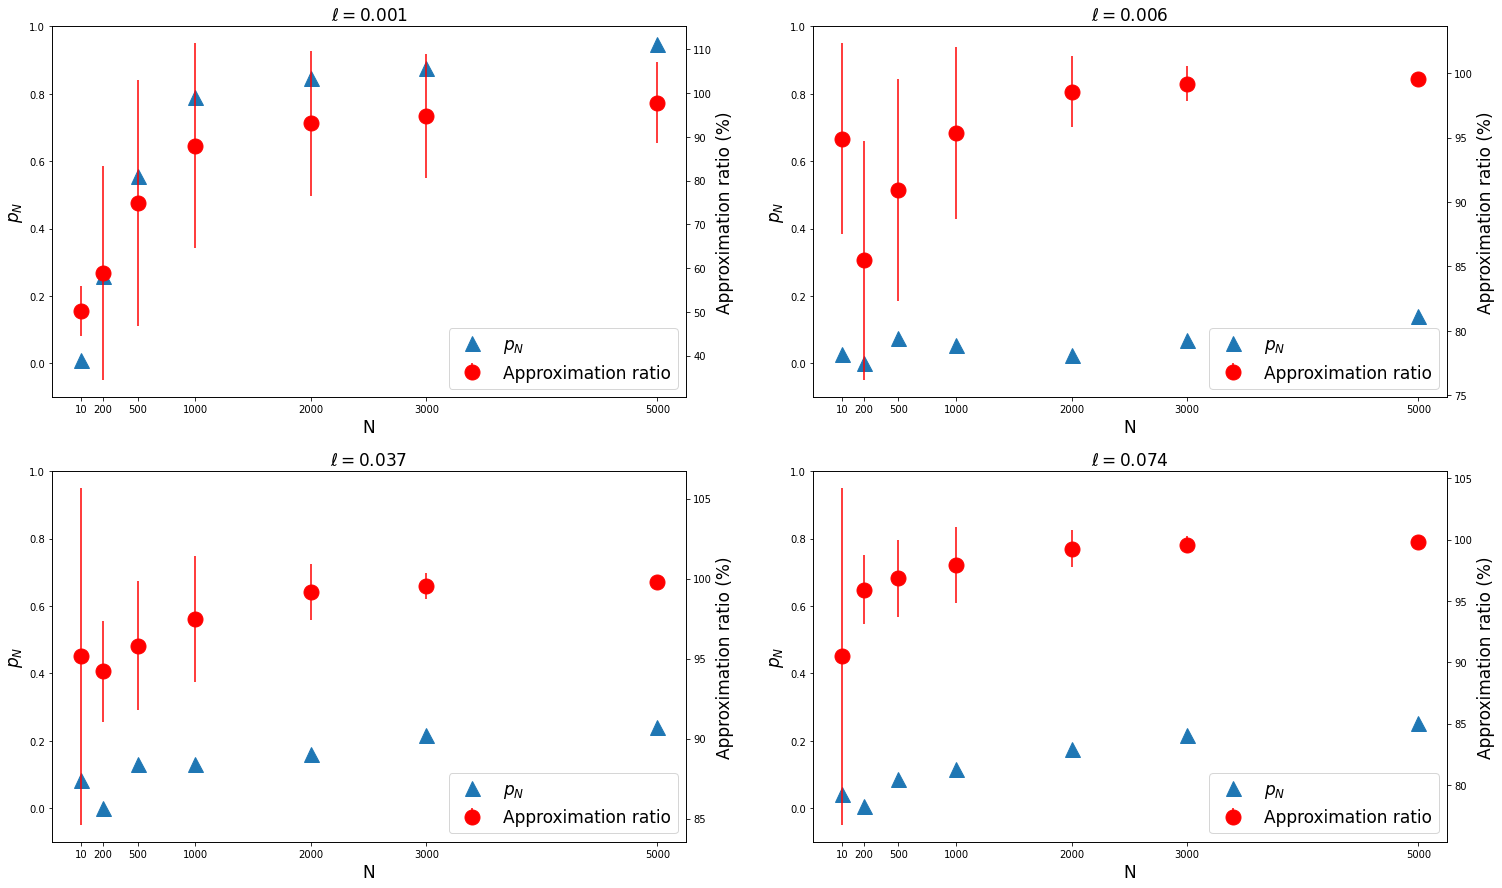

In [40]:
# Retrieve previously computed parameters
with open('pickle/Approx_list_all',"rb") as f:
    approximation_list_all = pickle.load(f)
with open('pickle/Proba_list_all',"rb") as f:
    proba_list_all = pickle.load(f)

# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(25,15))
indices = [[0, 0], [0, 1], [1, 0], [1, 1]] # Tool to make subplots on two lines
for index, l in enumerate(experiment_list):
    probas = proba_list_all[index]
    approximation_list = approximation_list_all[index]
    index1 = indices[index][0]
    index2 = indices[index][1]
    # Plot probability to obtain optimal
    axs[index1][index2].plot(
        N_list, probas, label=r'$p_N$', marker='^', markersize=15, linestyle='None')
    axs[index1][index2].set_xlabel("N", fontsize=17)
    axs[index1][index2].set_ylabel(r'$p_N$', fontsize=17)
    axs[index1][index2].set_title(r'$\ell = {}$'.format(round(l, 3)), fontsize=17)
    # Plot approximation ratio
    axs2 = axs[index1][index2].twinx()
    mean_approx = np.mean(approximation_list, axis=1)
    std_approx = np.std(approximation_list, axis=1)
    axs2.errorbar(N_list, mean_approx, std_approx, fmt='o', color='r', label='Approximation ratio', markersize=15)
    axs2.set_xlabel("N", fontsize=17)
    axs2.set_ylabel("Approximation ratio (%)", fontsize=17)
    axs[index1][index2].set_ylim(-0.1, 1)
    axs[index1][index2].set_xticks(N_list)
    h1, l1 = axs[index1][index2].get_legend_handles_labels()
    h2, l2 = axs2.get_legend_handles_labels()
    axs2.legend(h1+h2, l1+l2, loc='lower right', fontsize=17)

fig.savefig('plots/plot_approx_rate_fraud', dpi = 400, bbox_inches = 'tight')

# Evaluating the approximation data set of the same size as the kaggle data set

## Experiments (optional)

In [11]:
nb_run = 10
N = 284807 # Size of the kaggle data set
approx_list = []
proba_list = []
for l in list_l:
    # Computes equilibrium of the true problem
    CFA = cfa_base*l
    bne_full = computation.solve_defender(
                p, amount, m, loss_failure, gain_success, PN, CFA, [1])
    G_eql = computation.retrieve_gain_eql(bne_full, m)
    proba_detection = computation.give_probability(G_eql, loss_failure, gain_success)
    objective = (
            computation.compute_gain_defender(G_eql, [1], proba_detection, CFA, PN, p)
        )
    proba = 0
    current_list = []
    for seed in range(nb_run):
        # Equilibrium computation
        np.random.seed(seed)
        # Generating the training problem
        nb_attacks, nb_non_attacks = attack_non_attacks(p, N)
        p_training = nb_attacks/N
        v_list = np.random.choice(range(amount), nb_non_attacks, p=PN)  # List of randomly generated normal users vectors
        PN_sample, gain_success_sample, loss_failure_sample, CFA_sample = (
                sample_average_general(PN, gain_success, loss_failure, CFA, v_list))
        # Solving the training problem
        bne_sample = computation.solve_defender(
                p_training, nb_non_attacks, m, loss_failure_sample, gain_success_sample,
                PN_sample, CFA_sample, [1])
        G_sample = computation.retrieve_gain_eql(bne_sample, m)
        proba_detection = computation.give_probability(G_sample, loss_failure, gain_success)
        # Retrieve the true objective associated with the trained strategy
        objective_sample = (
            computation.compute_gain_defender(G_sample, [1], proba_detection, CFA, PN, p)
        )
        current_list.append(100*objective/objective_sample)
        if(G_sample == G_eql):
            proba += 1/nb_run
    proba_list.append(proba)
    approx_list.append(current_list)

# Save computation results
file = open('pickle/Approx_list_full_size', 'wb')
pickle.dump(approx_list, file)
file.close()

file = open('pickle/Proba_list_full_size', 'wb')
pickle.dump(proba_list, file)
file.close()

0.001
0.006210526315789474
0.011421052631578946
0.01663157894736842
0.021842105263157895
0.02705263157894737
0.03226315789473684
0.03747368421052632
0.04268421052631579
0.04789473684210526
0.05310526315789474
0.05831578947368421
0.06352631578947368
0.06873684210526315
0.07394736842105264
0.07915789473684211
0.08436842105263158
0.08957894736842105
0.09478947368421052
0.1
[0.7999999999999999, 0.2, 0.4, 0.30000000000000004, 0, 0.1, 0.1, 0.2, 0.30000000000000004, 0.2, 0.30000000000000004, 0.2, 0.1, 0.30000000000000004, 0.2, 0.1, 0.30000000000000004, 0.4, 0.4, 0.4]
[[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 58.139015507387555, 100.0, 54.57266532778164], [99.98580266291378, 99.98580266291378, 100.0, 100.0, 97.21933187250785, 99.25504336141532, 99.23984635846537, 97.72303402042988, 98.70548140411304, 95.6901714058915], [100.0, 100.0, 100.0, 100.0, 98.08302294582867, 99.24603549507368, 99.41483582260466, 98.22990658539214, 98.85008377438858, 96.95054002388633], [99.8991037519651, 100.0

## Plots (Figure 6)

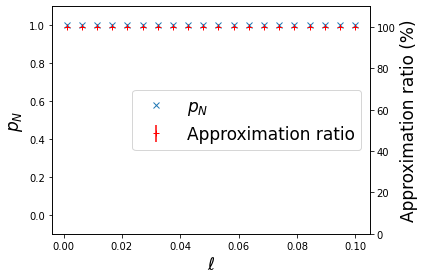

In [15]:
# Retrieve previously computed parameters
with open('pickle/Approx_list_full_size',"rb") as f:
    approximation_list = pickle.load(f)
with open('pickle/Proba_list_full_size',"rb") as f:
    proba_list = pickle.load(f)
    
# Plotting the results
fig, axs = plt.subplots(1, 1)
# Plot probability to obtain the optimal
axs.plot(list_l, proba_list, label=r'$p_N$', marker='x', linestyle='none')
axs.set_ylabel(r'$p_N$', fontsize=17)
# Plot approximation ratio
axs2 = axs.twinx()
mean_approx = np.mean(approximation_list, axis=1)
std_approx = np.std(approximation_list, axis=1)
axs2.errorbar(list_l, mean_approx, std_approx, fmt='+', color='r', label='Approximation ratio')
axs.set_xlabel(r'$\ell$', fontsize=17)
axs2.set_ylabel("Approximation ratio (%)", fontsize=17)
axs2.set_ylim([0, 110])
axs.set_ylim(-0.1, 1.1)
h1, l1 = axs.get_legend_handles_labels()
h2, l2 = axs2.get_legend_handles_labels()
axs2.legend(h1+h2, l1+l2, loc='center right', fontsize=17)
fig.tight_layout()
fig.savefig('plots/plot_approx_rate_full', dpi = 400, bbox_inches = 'tight')

# Training on random game

## Parameters

In [9]:
k = 19
p = 0.1
low = 10
up = 20
n = 2**k
T = 30000
m = 4

## Experiments

In [30]:
N_list = [10, 200, 500, 1000, 2000, 3000, 5000]
nb_run = 20

# Storing results
approximation_list = [[] for i in range(len(N_list))]
proba_list_all = []

for seed_game in range(10):
    probas = [0 for i in range(len(N_list))]
    # Computing the equilibrium of the true problem
    gain_success, loss_failure, CFA, PN = parameter_generator.random_vectors(n, m, low, up, seed_game)
    proba_attacker = parameter_generator.random_proba_attack(m, seed_game)
    attack_proba = 0.1
    filename = filename = 'equilibrium_parameters/solu_' + \
        str(k) + '_' + str(m) + '_' + str(p) + '_' + \
        str(low) + '_' + str(up) + '_' + str(seed_game)
    G_eql, objective, time = write_result.read_eql(filename, m) #  Equilibrium computation
    
    # For each l, we perform training on different training set size
    for i, N in enumerate(N_list):
        # For each training set size, we produce multiple random training sets
        for seed in range(nb_run):
            np.random.seed(seed)
            # Generating the training problem
            nb_attacks, nb_non_attacks = attack_non_attacks(p, N)
            p_training = nb_attacks/N
            v_list = np.random.choice(range(n), nb_non_attacks, p=PN)  # List of randomly generated normal users vectors
            PN_sample, gain_success_sample, loss_failure_sample, CFA_sample = (
                    sample_average_general(PN, gain_success, loss_failure, CFA, v_list))
            # Solving the training problem
            bne_sample = computation.solve_defender(
                    p_training, nb_non_attacks, m, loss_failure_sample, gain_success_sample,
                    PN_sample, CFA_sample, proba_attacker)
            G_sample = computation.retrieve_gain_eql(bne_sample, m)
            proba_detection = computation.give_probability(G_sample, loss_failure, gain_success)
            # Retrieve the true objective associated with the trained strategy
            objective_sample = (
                computation.compute_gain_defender(G_sample, proba_attacker, proba_detection, CFA, PN, p)
            )
            if(gradient.distance(G_sample, G_eql) < 1e-8):
                probas[i] += 1/nb_run
            approximation_list[i].append(100*objective/objective_sample)
    proba_list_all.append(probas)
    
# Save computation results
file = open('pickle/Approx_list_random', 'wb')
pickle.dump(approximation_list, file)
file.close()

file = open('pickle/Proba_list_all_random', 'wb')
pickle.dump(proba_list_all, file)
file.close()

## Plots (Figure 7)

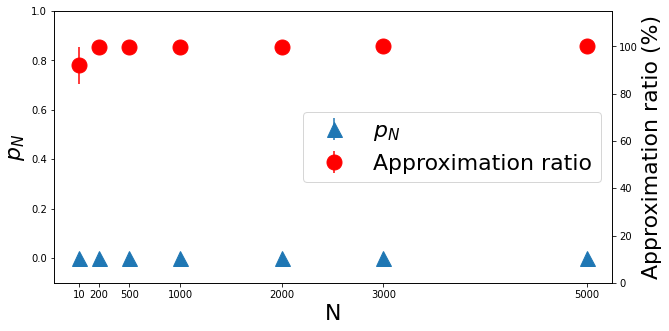

In [19]:
# Retrieve previously computed parameters
with open('pickle/Approx_list_random',"rb") as f:
    approximation_list = pickle.load(f)
with open('pickle/Proba_list_all_random',"rb") as f:
    proba_list_all = pickle.load(f)

N_list = [10, 200, 500, 1000, 2000, 3000, 5000]
# Plotting the results
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Plot probability to obtain the optimal
mean_probas = np.mean(proba_list_all, axis=0)
std_probas = np.std(proba_list_all, axis=0)
axs.errorbar(N_list, mean_probas, std_probas, label=r'$p_N$', fmt='^', markersize=15)
axs.set_xlabel("N", fontsize=22)
axs.set_ylabel(r'$p_N$', fontsize=22)
# Plot approximation ratio
axs2 = axs.twinx()
mean_approx = np.mean(approximation_list, axis=1)
std_approx = np.std(approximation_list, axis=1)
axs2.errorbar(N_list, mean_approx, std_approx, fmt='o', color='r', label='Approximation ratio', markersize=15)
axs2.set_xlabel("N", fontsize=17)
axs2.set_ylabel("Approximation ratio (%)", fontsize=22)
axs2.set_ylim([0, 115])
axs.set_ylim(-0.1, 1)
axs.set_xticks([10, 200, 500, 1000, 2000, 3000, 5000])
h1, l1 = axs.get_legend_handles_labels()
h2, l2 = axs2.get_legend_handles_labels()
axs2.legend(h1+h2, l1+l2, loc='center right', fontsize=22)

fig.savefig('plots/plot_approx_rate_random', dpi = 400, bbox_inches = 'tight')